In [1]:
import tensorflow
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm.notebook

from sklearn.preprocessing import LabelEncoder

In [2]:
#visulization functions (SR = Sample Rate)

def waveplot(audio,sr):
    plt.figure(figsize=(14, 5), dpi=100)
    return librosa.display.waveplot(audio, sr=sr)

def spectrogram(audio,sr):
    X = librosa.stft(audio)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(14, 5), dpi=100)
    return librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

def mfcc(audio,sr):
    mfccs = librosa.feature.mfcc(audio, sr=sr)
    return librosa.display.specshow(mfccs, sr=sr, x_axis='time')

In [3]:
def load_data(path,genres):
    data = []
    labels = []
    srs = []
    
    for genre in genres:
        for file in tqdm.notebook.tqdm(os.listdir(path + genre + "/"), desc = genre):
            x, sr = librosa.load(path + genre + "/" + file,duration=5)
            x = librosa.feature.melspectrogram(x, sr=sr,n_fft=2048, hop_length=512)
            x = librosa.power_to_db(x, ref=np.max)
                
            data.append(x)
            labels.append(genre)
            srs.append(sr)
            
    return np.array(data), np.array(labels), np.array(srs)

In [4]:
data_path = os.getcwd() + "/data/genres/"
genres = os.listdir(data_path)

In [5]:
X,Y, sr = load_data(data_path, genres)

In [6]:
X = X.reshape(-1, 128, 216, 1) / 255


le = LabelEncoder()
Y = le.fit_transform(Y)

In [7]:
from sklearn.model_selection import train_test_split

trn_x,val_x,trn_y,val_y = train_test_split(X,Y,test_size=0.10,shuffle=True)

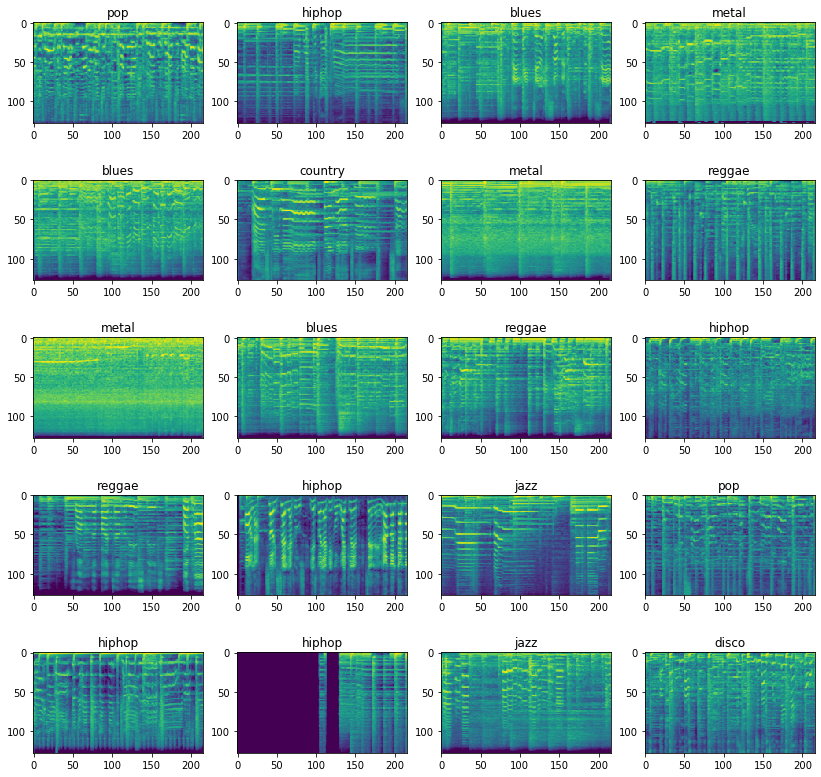

In [9]:
w=10
h=10
fig=plt.figure(figsize=(14, 14))

columns = 4
rows = 5

for i in range(1, columns*rows +1):
    img = trn_x[i].reshape(trn_x[i].shape[0], trn_x[i].shape[1])
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(le.inverse_transform(trn_y[i].reshape(-1,1))[0])
    plt.imshow(img)
plt.show()

In [10]:
shape = X[0].shape
shape

(128, 216, 1)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D, Dense, Dropout, Flatten
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv2D(32,input_shape=shape,kernel_size= (5,5),activation='relu'))
model.add(MaxPool2D(4,4))
model.add(Conv2D(16,input_shape=shape,kernel_size= (2,2),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(100,activation='relu'))
model.add(Dense(10,activation='softmax'))

In [12]:
adam = optimizers.Adam(lr=0.0001)

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=adam,
              metrics=['acc'])

In [13]:
k_es = tensorflow.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

history = model.fit(trn_x,trn_y,
                    batch_size=10,
                    epochs=100,
                    validation_data=(val_x,val_y),
                   callbacks=[k_es])

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 2s 2ms/sample - loss: 2.3014 - acc: 0.1011 - val_loss: 2.3003 - val_acc: 0.0800
Epoch 2/100
900/900 [==============================] - 1s 985us/sample - loss: 2.2902 - acc: 0.1111 - val_loss: 2.2873 - val_acc: 0.1800
Epoch 3/100
900/900 [==============================] - 1s 997us/sample - loss: 2.2737 - acc: 0.1333 - val_loss: 2.2678 - val_acc: 0.1300
Epoch 4/100
900/900 [==============================] - 1s 1000us/sample - loss: 2.2496 - acc: 0.1444 - val_loss: 2.2423 - val_acc: 0.0700
Epoch 5/100
900/900 [==============================] - 1s 1ms/sample - loss: 2.2123 - acc: 0.2278 - val_loss: 2.1844 - val_acc: 0.3200
Epoch 6/100
900/900 [==============================] - 1s 986us/sample - loss: 2.1450 - acc: 0.3311 - val_loss: 2.1121 - val_acc: 0.1600
Epoch 7/100
900/900 [==============================] - 1s 981us/sample - loss: 2.0304 - acc: 0.2944 - val_loss: 2.0108 - val_acc: 0.230

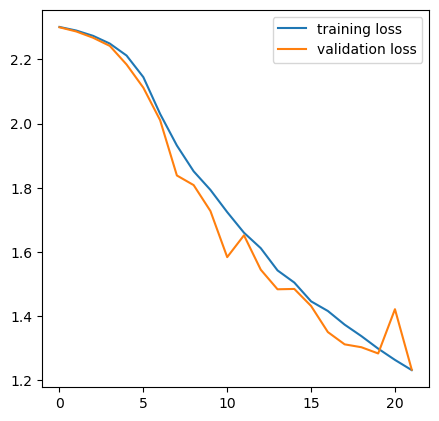

In [14]:
plt.figure(figsize=(5,5),dpi=100)
plt.plot(history.history['loss'],label='training loss')
plt.plot(history.history['val_loss'],label='validation loss')
plt.legend(loc='upper right')